# MACD Standalone Optimization

## Purpose
Optimize MACD parameters independently for later ensemble with 3EMA.

## Configuration
- `USE_VOLUME_FILTER`: Toggle volume confirmation on/off
- `VOLUME_THRESHOLD`: Volume multiplier (only if filter enabled)

## Strategy
- Entries: MACD bullish crossover (+ optional volume filter)
- Exits: MACD bearish crossover (+ optional volume filter)

## Data Split
- Training: 70% (2015-2022)
- Validation: 30% (2022-2025)


In [34]:
# !pip install yfinance
# !pip install TA-Lib
# !pip install numpy
# !pip install pandas
# !pip install vectorbt
# !pip install scipy
# %pip install scikit-optimize
# %pip install optuna



In [35]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import vectorbt as vbt
import warnings
from scipy import stats
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)



In [36]:
# DOWNLOAD STOCK DATA FROM 2018 USING YFINANCE

TICKER = 'INDA'
START_DATE = '2018-01-01'
TRAIN_RATIO = 0.6
# Download data
stock_data = yf.download(TICKER, start=START_DATE, interval='1d')

if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER}") 
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
else:
    print(f"Failed to download {TICKER} data")

stock_data



C:\Users\harka\AppData\Local\Temp\ipykernel_4588\2642765560.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1999 records for INDA
Data range: 2018-01-02 to 2025-12-15


Price,Close,High,Low,Open,Volume
Ticker,INDA,INDA,INDA,INDA,INDA
Date,,,,,
2018-01-02,32.862564,32.871659,32.726169,32.789821,2743900
2018-01-03,32.980774,32.980774,32.826189,32.826189,2458700
2018-01-04,33.126263,33.153541,33.008051,33.071703,4126700
2018-01-05,33.662762,33.662762,33.353595,33.371782,4364200
2018-01-08,33.635479,33.653662,33.517267,33.580919,2272800
...,...,...,...,...,...
2025-12-08,53.080002,53.459999,53.009998,53.330002,4126300
2025-12-09,53.270000,53.360001,53.139999,53.139999,5697000


In [37]:
# PREPARE PRICE SERIES

def select_close_series(df, ticker):
    if isinstance(df.columns, pd.MultiIndex):
        if ('Close', ticker) in df.columns:
            s = df[('Close', ticker)]
        else:
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        s = df['Close']
    return s.astype(float).squeeze()

close = select_close_series(stock_data, TICKER)
close.name = 'price'

# Simple split

split_idx = int(len(close) * TRAIN_RATIO)
train_close = close.iloc[:split_idx].copy()
val_close = close.iloc[split_idx:].copy()

print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")



Data ready: train=2018-01-02 → 2022-10-05 | val=2022-10-06 → 2025-12-15


# MACD Strategy Configuration

This notebook optimizes **MACD parameters independently** for later ensemble with 3EMA.

**Strategy Logic**: 
- Entries: MACD bullish crossover (+ optional volume filter)
- Exits: MACD bearish crossover (+ optional volume filter)

**Modular Optimization**: Find best MACD params separately, then combine with best 3EMA params.


In [38]:
# CONFIGURATION & Parameter Ranges for MACD Optimization

# CONFIGURATION
USE_VOLUME_FILTER = False # Toggle volume filter
VOLUME_THRESHOLD = 1.2   # Only used if USE_VOLUME_FILTER = True

param_bounds = {
    'macd_fast': (12, 200),
    'macd_slow': (26, 300),
    'macd_signal': (50, 500),
}

print("Parameter Bounds for Optimization:")
print(f"  MACD Fast: {param_bounds['macd_fast'][0]} - {param_bounds['macd_fast'][1]} periods")

close = select_close_series(stock_data, TICKER)
close.name = 'price'

print(f"Volume Threshold: {VOLUME_THRESHOLD}x")
print("\nConstraint: MACD Fast < MACD Slow")
print("✅ Ready for optimization!")



Parameter Bounds for Optimization:
  MACD Fast: 12 - 200 periods
Volume Threshold: 1.2x

Constraint: MACD Fast < MACD Slow
✅ Ready for optimization!


In [39]:
# Core Optimization Function for MACD Strategy

def evaluate_macd_strategy(params, data=train_close, stock_data_for_volume=None, return_metrics=False):
    """
    Evaluate standalone MACD strategy.
    
    Args:
        params: tuple of (macd_fast, macd_slow, macd_signal)
        data: price data to test on
        stock_data_for_volume: full stock data with volume (required if USE_VOLUME_FILTER=True)
        return_metrics: if True, return full metrics dict; if False, return negative Sortino ratio
    
    Returns:
        Negative Sortino ratio (for minimization) or full metrics dict
    """
    macd_fast, macd_slow, macd_signal = params
    
    # Validate parameter constraints
    if macd_fast >= macd_slow:
        return 999.0  # Large penalty for invalid parameters
    
    try:
        # Calculate MACD
        close_array = data.values
        macd, macd_signal_line, macd_hist = talib.MACD(
            close_array,
            fastperiod=int(macd_fast),
            slowperiod=int(macd_slow),
            signalperiod=int(macd_signal)
        )
        
        macd_series = pd.Series(macd, index=data.index)
        signal_series = pd.Series(macd_signal_line, index=data.index)
        
        # MACD crossovers
        macd_bullish = (macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1))
        macd_bearish = (macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1))
        
        if USE_VOLUME_FILTER:
            # Apply volume confirmation
            if stock_data_for_volume is None:
                return 999.0
            
            volume_data = stock_data_for_volume['Volume']
            volume_aligned = volume_data.reindex(data.index)
            volume_sma = volume_aligned.rolling(window=20).mean()
            volume_ratio = volume_aligned / volume_sma
            volume_confirm = volume_ratio > VOLUME_THRESHOLD
            
            entries = pd.Series(macd_bullish & volume_confirm, index=data.index).fillna(False)
            exits = pd.Series(macd_bearish & volume_confirm, index=data.index).fillna(False)
        else:
            # Pure MACD crossovers (no volume filter)
            entries = pd.Series(macd_bullish, index=data.index).fillna(False)
            exits = pd.Series(macd_bearish, index=data.index).fillna(False)
        
        # Backtest
        portfolio = vbt.Portfolio.from_signals(
            close=data,
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq='D'
        )
        
        # Calculate key metrics
        sharpe_ratio = float(portfolio.sharpe_ratio(freq='D'))
        sortino_ratio = float(portfolio.sortino_ratio(freq='D'))
        total_return = float(portfolio.total_return())
        max_drawdown = float(portfolio.max_drawdown())
        volatility = float(portfolio.annualized_volatility(freq='D'))
        
        # Trade metrics
        trades = portfolio.trades
        total_trades = len(trades)
        
        # Check for sufficient trading activity
        years = max((data.index[-1] - data.index[0]).days / 365.25, 1e-9)
        trades_per_year = total_trades / years
        
        if trades_per_year < 1:  # Too few trades
            if return_metrics:
                return {
                    'macd_fast': macd_fast,
                    'macd_slow': macd_slow,
                    'macd_signal': macd_signal,
                    'sharpe_ratio': np.nan,
                    'sortino_ratio': np.nan,
                    'total_return': np.nan,
                    'annualized_return': np.nan,
                    'max_drawdown': np.nan,
                    'volatility': np.nan,
                    'total_trades': total_trades,
                    'win_rate': np.nan,
                    'profit_factor': np.nan,
                    'expectancy': np.nan,
                    'trades_per_year': trades_per_year
                }
            return 999.0
        
        if return_metrics:
            # Calculate additional metrics
            win_rate_pct = np.nan
            profit_factor = np.nan
            expectancy = 0.0
            annualized_return = (1.0 + total_return) ** (1.0 / years) - 1.0 if years > 0 else np.nan
            
            if total_trades > 0:
                tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
                if tr.size > 0:
                    pos = tr[tr > 0]
                    neg = tr[tr < 0]
                    win_rate_pct = (len(pos) / len(tr)) * 100.0
                    gains = pos.sum() if len(pos) else 0.0
                    losses = abs(neg.sum()) if len(neg) else 0.0
                    profit_factor = (gains / losses) if losses > 0 else np.inf
                    expectancy = float(tr.mean())
            
            return {
                'macd_fast': macd_fast,
                'macd_slow': macd_slow,
                'macd_signal': macd_signal,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'max_drawdown': max_drawdown,
                'volatility': volatility,
                'total_trades': total_trades,
                'win_rate': win_rate_pct,
                'profit_factor': profit_factor,
                'expectancy': expectancy,
                'trades_per_year': trades_per_year
            }
        else:
            # Return negative Sortino for minimization
            return -sortino_ratio
            
    except Exception as e:
        return 999.0  # Large penalty for errors

print("✅ MACD evaluation function created!")
print(f"Volume filter: {'ENABLED' if USE_VOLUME_FILTER else 'DISABLED'}")



✅ MACD evaluation function created!
Volume filter: DISABLED


In [40]:
# OPTUNA OPTIMIZATION - MACD Strategy

print("=" * 70)
print(f"OPTUNA OPTIMIZATION: MACD Strategy")
print(f"Volume Filter: {'ENABLED' if USE_VOLUME_FILTER else 'DISABLED'}")
print(f"Training Period: {train_close.index[0].date()} → {train_close.index[-1].date()}")
print("=" * 70)

import optuna

evaluation_count = 0

def objective(trial):
    """Optuna objective function for MACD."""
    global evaluation_count
    evaluation_count += 1
    
    # Suggest MACD parameters
    macd_fast = trial.suggest_int('macd_fast', param_bounds['macd_fast'][0], param_bounds['macd_fast'][1])
    macd_slow = trial.suggest_int('macd_slow', param_bounds['macd_slow'][0], param_bounds['macd_slow'][1])
    macd_signal = trial.suggest_int('macd_signal', param_bounds['macd_signal'][0], param_bounds['macd_signal'][1])
    
    # Validate constraints
    if macd_fast >= macd_slow:
        return 999.0
    
    # Evaluate strategy
    result = evaluate_macd_strategy(
        (macd_fast, macd_slow, macd_signal),
        stock_data_for_volume=stock_data.iloc[:split_idx] if USE_VOLUME_FILTER else None
    )
    
    # Debug output
    if result == 999.0 and evaluation_count <= 5:
        print(f"Trial {evaluation_count}: MACD({macd_fast},{macd_slow},{macd_signal}) → No valid trades")
    elif evaluation_count % 20 == 0 or result != 999.0:
        print(f"Trial {evaluation_count}: MACD({macd_fast},{macd_slow},{macd_signal}) → Sortino: {-result:.3f}")
    
    return result

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=1000, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_macd_fast = best_params['macd_fast']
best_macd_slow = best_params['macd_slow']
best_macd_signal = best_params['macd_signal']
best_sortino = -study.best_value

# Evaluate with full metrics
best_result = evaluate_macd_strategy(
    (best_macd_fast, best_macd_slow, best_macd_signal),
    stock_data_for_volume=stock_data.iloc[:split_idx] if USE_VOLUME_FILTER else None,
    return_metrics=True
)

results_df = pd.DataFrame([best_result])

print("\n✅ Optimization complete!")
print(f"Best Parameters: MACD({best_macd_fast},{best_macd_slow},{best_macd_signal})")
print(f"Sortino Ratio: {best_sortino:.3f}")


[I 2025-12-15 18:27:25,510] A new study created in memory with name: no-name-90a4e6a8-cd52-49c5-ae96-5190ccdd1c37


OPTUNA OPTIMIZATION: MACD Strategy
Volume Filter: DISABLED
Training Period: 2018-01-02 → 2022-10-05


  0%|          | 0/1000 [00:00<?, ?it/s]

Trial 1: MACD(82,287,380) → No valid trades
[I 2025-12-15 18:27:25,598] Trial 0 finished with value: 999.0 and parameters: {'macd_fast': 82, 'macd_slow': 287, 'macd_signal': 380}. Best is trial 0 with value: 999.0.
[I 2025-12-15 18:27:25,601] Trial 1 finished with value: 999.0 and parameters: {'macd_fast': 125, 'macd_slow': 68, 'macd_signal': 120}. Best is trial 0 with value: 999.0.
Trial 3: MACD(22,264,321) → No valid trades
[I 2025-12-15 18:27:25,643] Trial 2 finished with value: 999.0 and parameters: {'macd_fast': 22, 'macd_slow': 264, 'macd_signal': 321}. Best is trial 0 with value: 999.0.
[I 2025-12-15 18:27:25,651] Trial 3 finished with value: 999.0 and parameters: {'macd_fast': 145, 'macd_slow': 31, 'macd_signal': 487}. Best is trial 0 with value: 999.0.
[I 2025-12-15 18:27:25,658] Trial 4 finished with value: 999.0 and parameters: {'macd_fast': 169, 'macd_slow': 84, 'macd_signal': 132}. Best is trial 0 with value: 999.0.
Trial 6: MACD(46,109,286) → Sortino: 0.939
[I 2025-12-15 

In [41]:
# BENCHMARK ANALYSIS: Best Strategy vs Market (Buy & Hold) - ENHANCED

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    macd_fast, macd_slow, macd_signal = int(best['macd_fast']), int(best['macd_slow']), int(best['macd_signal'])

    print(f"BENCHMARK ANALYSIS: Best MACD({macd_fast},{macd_slow},{macd_signal}) vs Buy & Hold")
    print("=" * 70)

    # Recreate the BEST strategy portfolio to get returns
    close_array = train_close.values
    macd, macd_signal_line, macd_hist = talib.MACD(
        close_array,
        fastperiod=macd_fast,
        slowperiod=macd_slow,
        signalperiod=macd_signal
    )
    
    macd_series = pd.Series(macd, index=train_close.index)
    signal_series = pd.Series(macd_signal_line, index=train_close.index)
    
    # MACD crossover signals
    entries = (macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1))
    exits = (macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1))
    
    entries = pd.Series(entries, index=train_close.index).fillna(False)
    exits = pd.Series(exits, index=train_close.index).fillna(False)

    best_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq='D'
    )

    # Create buy & hold benchmark
    benchmark_entries = np.zeros(len(train_close), dtype=bool)
    benchmark_entries[0] = True
    benchmark_exits = np.zeros(len(train_close), dtype=bool)

    benchmark_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=benchmark_entries,
        exits=benchmark_exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )

    # Get returns for comparison
    strategy_returns = best_pf.returns().dropna()
    benchmark_returns = benchmark_pf.returns().dropna()

    # Benchmark metrics
    bench_total_return = benchmark_pf.total_return()
    bench_annualized_return = benchmark_pf.annualized_return(freq='D')
    bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
    bench_sortino = benchmark_pf.sortino_ratio(freq='D')
    bench_max_drawdown = benchmark_pf.max_drawdown()
    bench_volatility = benchmark_pf.annualized_volatility(freq='D')

    # Strategy annualized return
    strategy_annualized_return = best['annualized_return']

    # Performance comparison
    print("\nPERFORMANCE COMPARISON:")
    print(f"Strategy (MACD {macd_fast},{macd_slow},{macd_signal}):")
    print(f"  Total Return:      {best['total_return']:.2%}")
    print(f"  Annualized Return: {strategy_annualized_return:.2%}")
    print(f"  Sharpe Ratio:      {best['sharpe_ratio']:.3f}")
    print(f"  Sortino Ratio:     {best['sortino_ratio']:.3f}")
    print(f"  Max Drawdown:      {best['max_drawdown']:.2%}")
    print(f"  Volatility:        {best['volatility']:.2%}")
    print(f"  Total Trades:      {best['total_trades']}")
    print(f"  Win Rate:          {best['win_rate']:.1f}%")
    print(f"  Profit Factor:     {best['profit_factor']:.2f}")

    print(f"\nBenchmark (Buy & Hold {TICKER}):")
    print(f"  Total Return:      {bench_total_return:.2%}")
    print(f"  Annualized Return: {bench_annualized_return:.2%}")
    print(f"  Sharpe Ratio:      {bench_sharpe:.3f}")
    print(f"  Sortino Ratio:     {bench_sortino:.3f}")
    print(f"  Max Drawdown:      {bench_max_drawdown:.2%}")
    print(f"  Volatility:        {bench_volatility:.2%}")

    # Outperformance metrics
    excess_return = best['total_return'] - bench_total_return
    excess_annualized_return = strategy_annualized_return - bench_annualized_return
    sharpe_diff = best['sharpe_ratio'] - bench_sharpe
    sortino_diff = best['sortino_ratio'] - bench_sortino
    excess_max_drawdown = best['max_drawdown'] - bench_max_drawdown

    print(f"\nOUTPERFORMANCE METRICS:")
    print(f"  Excess Return:           {excess_return:.2%}")
    print(f"  Excess Annualized Return: {excess_annualized_return:.2%}")
    print(f"  Sharpe Difference:       {sharpe_diff:.3f}")
    print(f"  Sortino Difference:      {sortino_diff:.3f}")
    print(f"  Excess Max Drawdown:      {excess_max_drawdown:.2%} ({'Better' if excess_max_drawdown > 0 else '❌ Worse'})")
    
    # Calculate beta
    market_beta = best['volatility'] / bench_volatility if bench_volatility != 0 else np.nan
    print(f"  Market Beta (approx):     {market_beta:.3f} ({'Lower risk' if market_beta < 1 else '⚠️ Higher risk'})")
else:
    print("⚠️ No results available for benchmark analysis.")


BENCHMARK ANALYSIS: Best MACD(38,57,115) vs Buy & Hold

PERFORMANCE COMPARISON:
Strategy (MACD 38,57,115):
  Total Return:      79.09%
  Annualized Return: 13.04%
  Sharpe Ratio:      1.213
  Sortino Ratio:     1.793
  Max Drawdown:      -9.71%
  Volatility:        15.64%
  Total Trades:      7.0
  Win Rate:          57.1%
  Profit Factor:     12.51

Benchmark (Buy & Hold INDA):
  Total Return:      25.44%
  Annualized Return: 7.14%
  Sharpe Ratio:      0.378
  Sortino Ratio:     0.519
  Max Drawdown:      -45.07%
  Volatility:        31.84%

OUTPERFORMANCE METRICS:
  Excess Return:           53.65%
  Excess Annualized Return: 5.89%
  Sharpe Difference:       0.835
  Sortino Difference:      1.273
  Excess Max Drawdown:      35.36% (Better)
  Market Beta (approx):     0.491 (Lower risk)


In [42]:
# IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON

FREQ = "1D"

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    macd_fast, macd_slow, macd_signal = int(best['macd_fast']), int(best['macd_slow']), int(best['macd_signal'])

    # Out-of-sample validation
    close_array_val = val_close.values
    macd_val, macd_signal_line_val, _ = talib.MACD(
        close_array_val,
        fastperiod=macd_fast,
        slowperiod=macd_slow,
        signalperiod=macd_signal
    )
    
    macd_series_val = pd.Series(macd_val, index=val_close.index)
    signal_series_val = pd.Series(macd_signal_line_val, index=val_close.index)
    
    entries_val = pd.Series((macd_series_val > signal_series_val) & (macd_series_val.shift(1) <= signal_series_val.shift(1)), index=val_close.index).fillna(False)
    exits_val = pd.Series((macd_series_val < signal_series_val) & (macd_series_val.shift(1) >= signal_series_val.shift(1)), index=val_close.index).fillna(False)

    pf_val = vbt.Portfolio.from_signals(
        close=val_close,
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    # Out-of-sample metrics
    val_total_return = pf_val.total_return()
    val_annualized_return = pf_val.annualized_return(freq=FREQ)
    val_sharpe = pf_val.sharpe_ratio(freq=FREQ)
    val_sortino = pf_val.sortino_ratio(freq=FREQ)
    val_max_drawdown = pf_val.max_drawdown()
    val_volatility = pf_val.annualized_volatility(freq=FREQ)

    trades_val = pf_val.trades
    val_total_trades = len(trades_val)
    years = max((val_close.index[-1] - val_close.index[0]).days / 365.25, 1e-9)
    val_trades_per_year = val_total_trades / years

    val_win_rate_pct = np.nan
    val_profit_factor = np.nan
    val_expectancy = 0.0
    if val_total_trades > 0:
        tr = trades_val.returns.values if hasattr(trades_val.returns, 'values') else np.array(trades_val.returns)
        if tr.size > 0:
            pos = tr[tr > 0]
            neg = tr[tr < 0]
            val_win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) > 0 else np.nan
            gains = pos.sum() if len(pos) else 0.0
            losses = abs(neg.sum()) if len(neg) else 0.0
            val_profit_factor = gains / losses if losses > 0 else np.inf
            val_expectancy = tr.mean()

    def chg(before, after):
        if pd.isna(before) or pd.isna(after) or before == 0:
            return "N/A"
        return f"{((after - before) / abs(before)) * 100:+.1f}%"

    print(f"IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best MACD({macd_fast},{macd_slow},{macd_signal})")
    print("=" * 80)

    print(f"{'METRIC':<25} {'IN-SAMPLE':<15} {'OUT-OF-SAMPLE':<15} {'DEGRADATION':<15}")

    print("\nRETURN METRICS:")
    print(f"{'Total Return':<25} {best['total_return']:<15.2%} {val_total_return:<15.2%} {chg(best['total_return'], val_total_return)}")
    print(f"{'Annualized Return':<25} {best['annualized_return']:<15.2%} {val_annualized_return:<15.2%} {chg(best['annualized_return'], val_annualized_return)}")

    print("\nRISK-ADJUSTED METRICS:")
    print(f"{'Sharpe Ratio':<25} {best['sharpe_ratio']:<15.3f} {val_sharpe:<15.3f} {chg(best['sharpe_ratio'], val_sharpe)}")
    print(f"{'Sortino Ratio':<25} {best['sortino_ratio']:<15.3f} {val_sortino:<15.3f} {chg(best['sortino_ratio'], val_sortino)}")

    print("\nRISK METRICS:")
    print(f"{'Max Drawdown':<25} {best['max_drawdown']:<15.2%} {val_max_drawdown:<15.2%} {chg(best['max_drawdown'], val_max_drawdown)}")
    print(f"{'Volatility':<25} {best['volatility']:<15.2%} {val_volatility:<15.2%} {chg(best['volatility'], val_volatility)}")

    print("\nTRADE METRICS:")
    print(f"{'Total Trades':<25} {best['total_trades']:<15.0f} {val_total_trades:<15.0f} {chg(best['total_trades'], val_total_trades)}")
    print(f"{'Trades per Year':<25} {best['trades_per_year']:<15.1f} {val_trades_per_year:<15.1f} {chg(best['trades_per_year'], val_trades_per_year)}")
    print(f"{'Win Rate %':<25} {best['win_rate']:<15.1f} {val_win_rate_pct:<15.1f} {chg(best['win_rate'], val_win_rate_pct)}")
    print(f"{'Profit Factor':<25} {best['profit_factor']:<15.2f} {val_profit_factor:<15.2f} {chg(best['profit_factor'], val_profit_factor)}")
    print(f"{'Expectancy':<25} {best['expectancy']:<15.4f} {val_expectancy:<15.4f} {chg(best['expectancy'], val_expectancy)}")
else:
    print("⚠️ No results for comparison.")


IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best MACD(38,57,115)
METRIC                    IN-SAMPLE       OUT-OF-SAMPLE   DEGRADATION    

RETURN METRICS:
Total Return              79.09%          6.72%           -91.5%
Annualized Return         13.04%          3.01%           -76.9%

RISK-ADJUSTED METRICS:
Sharpe Ratio              1.213           0.350           -71.1%
Sortino Ratio             1.793           0.492           -72.5%

RISK METRICS:
Max Drawdown              -9.71%          -9.77%          -0.7%
Volatility                15.64%          9.84%           -37.0%

TRADE METRICS:
Total Trades              7               5               -28.6%
Trades per Year           1.5             1.6             +6.4%
Win Rate %                57.1            60.0            +5.0%
Profit Factor             12.51           2.02            -83.8%
Expectancy                0.1044          0.0142          -86.4%


In [43]:
# OUT-OF-SAMPLE BENCHMARK COMPARISON

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    macd_fast, macd_slow, macd_signal = int(best['macd_fast']), int(best['macd_slow']), int(best['macd_signal'])

    print(f"OUT-OF-SAMPLE BENCHMARK: Best MACD({macd_fast},{macd_slow},{macd_signal}) vs Buy & Hold")
    print("=" * 70)

    # Use validation data
    close_data = val_close
    
    # Recreate the BEST strategy portfolio with MACD
    close_array = close_data.values
    macd, macd_signal_line, _ = talib.MACD(
        close_array,
        fastperiod=macd_fast,
        slowperiod=macd_slow,
        signalperiod=macd_signal
    )
    
    macd_series = pd.Series(macd, index=close_data.index)
    signal_series = pd.Series(macd_signal_line, index=close_data.index)
    
    entries = pd.Series((macd_series > signal_series) & (macd_series.shift(1) <= signal_series.shift(1)), index=close_data.index).fillna(False)
    exits = pd.Series((macd_series < signal_series) & (macd_series.shift(1) >= signal_series.shift(1)), index=close_data.index).fillna(False)

    strategy_pf = vbt.Portfolio.from_signals(
        close=close_data,
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq='D'
    )

    # Buy & hold benchmark
    benchmark_entries = np.zeros(len(close_data), dtype=bool)
    benchmark_entries[0] = True
    benchmark_exits = np.zeros(len(close_data), dtype=bool)

    benchmark_pf = vbt.Portfolio.from_signals(
        close=close_data,
        entries=benchmark_entries,
        exits=benchmark_exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )

    # Benchmark metrics
    bench_total_return = benchmark_pf.total_return()
    bench_annualized_return = benchmark_pf.annualized_return(freq='D')
    bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
    bench_sortino = benchmark_pf.sortino_ratio(freq='D')
    bench_max_drawdown = benchmark_pf.max_drawdown()
    bench_volatility = benchmark_pf.annualized_volatility(freq='D')

    # Strategy metrics
    trades_val = strategy_pf.trades
    val_total_trades = len(trades_val)
    years = max((close_data.index[-1] - close_data.index[0]).days / 365.25, 1e-9)
    
    val_win_rate_pct = np.nan
    val_profit_factor = np.nan
    val_expectancy = 0.0
    
    if val_total_trades > 0:
        tr = trades_val.returns.values if hasattr(trades_val.returns, 'values') else np.array(trades_val.returns)
        if tr.size > 0:
            pos = tr[tr > 0]
            neg = tr[tr < 0]
            val_win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) > 0 else np.nan
            gains = pos.sum() if len(pos) else 0.0
            losses = abs(neg.sum()) if len(neg) else 0.0
            val_profit_factor = gains / losses if losses > 0 else np.inf
            val_expectancy = tr.mean()

    strategy_total_return = strategy_pf.total_return()
    strategy_annualized_return = strategy_pf.annualized_return(freq='D')
    strategy_sharpe = strategy_pf.sharpe_ratio(freq='D')
    strategy_sortino = strategy_pf.sortino_ratio(freq='D')
    strategy_max_drawdown = strategy_pf.max_drawdown()
    strategy_volatility = strategy_pf.annualized_volatility(freq='D')

    # Performance comparison
    print(f"\n{'METRIC':<30} {'STRATEGY':<20} {'BUY & HOLD':<15} {'OUTPERFORMANCE':<15}")
    print("=" * 80)
    
    print(f"\nRETURN METRICS:")
    excess_return = strategy_total_return - bench_total_return
    print(f"{'Total Return':<30} {strategy_total_return:>20.2%} {bench_total_return:>15.2%} {excess_return:>+15.2%}")
    
    excess_annual = strategy_annualized_return - bench_annualized_return
    print(f"{'Annualized Return':<30} {strategy_annualized_return:>20.2%} {bench_annualized_return:>15.2%} {excess_annual:>+15.2%}")

    print(f"\nRISK-ADJUSTED METRICS:")
    excess_sharpe = strategy_sharpe - bench_sharpe
    print(f"{'Sharpe Ratio':<30} {strategy_sharpe:>20.3f} {bench_sharpe:>15.3f} {excess_sharpe:>+15.3f}")
    
    excess_sortino = strategy_sortino - bench_sortino
    print(f"{'Sortino Ratio':<30} {strategy_sortino:>20.3f} {bench_sortino:>15.3f} {excess_sortino:>+15.3f}")

    print(f"\nRISK METRICS:")
    excess_dd = strategy_max_drawdown - bench_max_drawdown
    print(f"{'Max Drawdown':<30} {strategy_max_drawdown:>20.2%} {bench_max_drawdown:>15.2%} {excess_dd:>+15.2%}")
    
    excess_vol = strategy_volatility - bench_volatility
    print(f"{'Volatility':<30} {strategy_volatility:>20.2%} {bench_volatility:>15.2%} {excess_vol:>+15.2%}")

    print(f"\nTRADE METRICS:")
    print(f"{'Total Trades':<30} {val_total_trades:>20.0f}")
    print(f"{'Win Rate %':<30} {val_win_rate_pct:>20.1f}")
    print(f"{'Profit Factor':<30} {val_profit_factor:>20.2f}")
    print(f"{'Expectancy':<30} {val_expectancy:>20.4f}")

    print(f"\n✅ Out-of-sample evaluation complete!")
    print(f"📊 Period: {close_data.index[0].date()} → {close_data.index[-1].date()}")
    
    # Summary verdict
    if strategy_total_return > bench_total_return and strategy_sharpe > bench_sharpe:
        print(f"🏆 Strategy OUTPERFORMS Buy & Hold on validation set!")
    elif strategy_total_return > bench_total_return:
        print(f"📈 Strategy has higher returns but Buy & Hold has better Sharpe")
    elif strategy_sharpe > bench_sharpe:
        print(f"💪 Strategy has better risk-adjusted returns despite lower total return")
    else:
        print(f"⚠️ Strategy underperforms Buy & Hold on validation set")
else:
    print("⚠️ No results available.")


OUT-OF-SAMPLE BENCHMARK: Best MACD(38,57,115) vs Buy & Hold

METRIC                         STRATEGY             BUY & HOLD      OUTPERFORMANCE 

RETURN METRICS:
Total Return                                  6.72%          30.46%         -23.75%
Annualized Return                             3.01%          12.90%          -9.89%

RISK-ADJUSTED METRICS:
Sharpe Ratio                                  0.350           0.829          -0.479
Sortino Ratio                                 0.492           1.169          -0.677

RISK METRICS:
Max Drawdown                                 -9.77%         -18.67%          +8.90%
Volatility                                    9.84%          16.22%          -6.37%

TRADE METRICS:
Total Trades                                      5
Win Rate %                                     60.0
Profit Factor                                  2.02
Expectancy                                   0.0142

✅ Out-of-sample evaluation complete!
📊 Period: 2022-10-06 → 2025-12-15

In [44]:
# VISUALS: Signals + Equity Curves - BEST STRATEGY

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Build full sample EMAs and signals
    ema1_full = vbt.MA.run(close, ema1, ewm=True).ma
    ema2_full = vbt.MA.run(close, ema2, ewm=True).ma
    ema3_full = vbt.MA.run(close, ema3, ewm=True).ma

    # Triple EMA crossover signals
    entries_1 = ema1_full.vbt.crossed_above(ema2_full)
    entries_2 = ema1_full.vbt.crossed_above(ema3_full)
    entries_3 = ema2_full.vbt.crossed_above(ema3_full)
    entries_full = (entries_1 | entries_2 | entries_3)
    
    exits_1 = ema1_full.vbt.crossed_below(ema2_full)
    exits_2 = ema1_full.vbt.crossed_below(ema3_full)
    exits_3 = ema2_full.vbt.crossed_below(ema3_full)
    exits_full = (exits_1 | exits_2 | exits_3)

    entries_full = entries_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)

    # 1) Price + Triple EMAs + signals (full sample)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, close.values, label='Close', color='black', linewidth=1.5, alpha=0.7)
    ax.plot(close.index, ema1_full.values, label=f'Fast EMA ({ema1})', color='blue', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema2_full.values, label=f'Medium EMA ({ema2})', color='orange', alpha=0.8, linewidth=1.2)
    ax.plot(close.index, ema3_full.values, label=f'Slow EMA ({ema3})', color='purple', alpha=0.8, linewidth=1.2)

    buy_idx = close.index[entries_full]
    sell_idx = close.index[exits_full]
    ax.scatter(buy_idx, close.reindex(buy_idx).values, marker='^', color='green', s=80, label='Buy', zorder=5)
    ax.scatter(sell_idx, close.reindex(sell_idx).values, marker='v', color='red', s=80, label='Sell', zorder=5)

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Full Sample Signals', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # 2) Equity curves: train / val / full
    price_full = close.to_numpy(dtype=float)
    entries_train = entries_full[:split_idx]
    exits_train = exits_full[:split_idx]
    entries_val = entries_full[split_idx:]
    exits_val = exits_full[split_idx:]

    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_train = vbt.Portfolio.from_signals(
        close=train_close.to_numpy(dtype=float),
        entries=entries_train,
        exits=exits_train,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    pf_val2 = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    eq_full = (1 + pf_full.returns()).cumprod()
    eq_train = (1 + pf_train.returns()).cumprod()
    eq_val = (1 + pf_val2.returns()).cumprod()

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(close.index, eq_full.values, label='Full Sample', color='black', linewidth=2)
    ax.plot(train_close.index, eq_train.values, label='Train (In-Sample)', color='blue', linewidth=1.5, alpha=0.8)
    ax.plot(val_close.index, eq_val.values, label='Validation (Out-of-Sample)', color='orange', linewidth=1.5, alpha=0.8)

    # Add vertical line to show train/val split
    ax.axvline(x=train_close.index[-1], color='red', linestyle='--', alpha=0.5, label='Train/Val Split')

    ax.set_title(f'Best Triple EMA({ema1},{ema2},{ema3}) - Equity Curves', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Returns (normalized to 1)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(f"✅ Visualizations complete for best strategy: EMA({ema1},{ema2},{ema3})")
else:
    print("⚠️ No results to visualize.")


KeyError: 'ema1_period'

Total trades plotted: 31
Win Rate: 48.4% (15W / 16L)
Avg Win: 32.72% | Avg Loss: -5.82%
Max Win: 126.45% | Max Loss: -11.18%


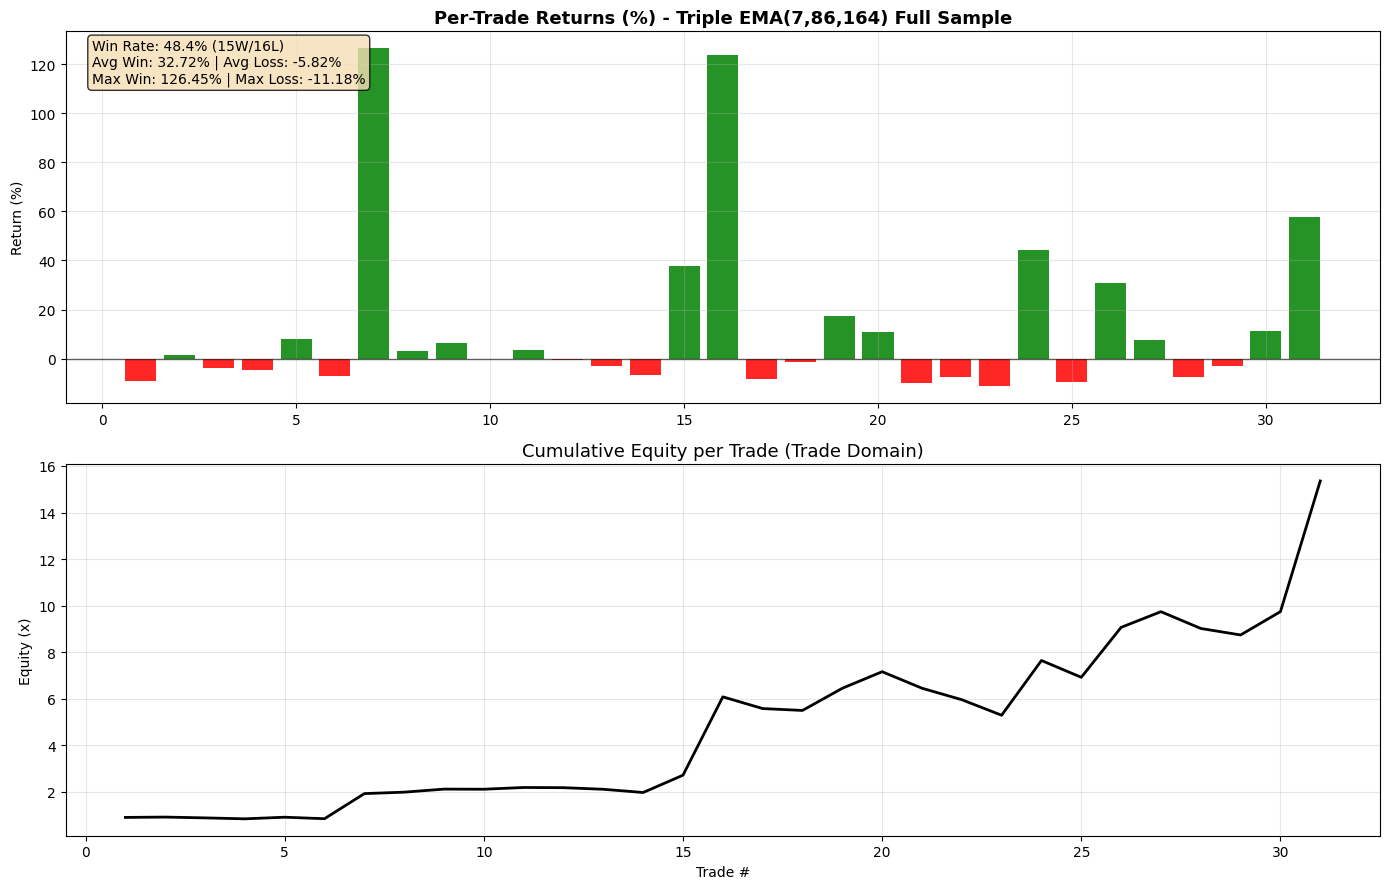

In [ ]:
# TRADE-BY-TRADE RETURNS (BAR) + CUMULATIVE PER-TRADE EQUITY

if 'results_df' not in globals() or results_df.empty:
    print("⚠️ No results available.")
else:
    best = results_df.iloc[0]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    # Resolve full close series
    full_close = close.astype(float)

    # Indicators
    ema1_full = vbt.MA.run(full_close, ema1, ewm=True)
    ema2_full = vbt.MA.run(full_close, ema2, ewm=True)
    ema3_full = vbt.MA.run(full_close, ema3, ewm=True)

    # Signals
    entries_raw = (
        ema1_full.ma_crossed_above(ema2_full.ma) |
        ema1_full.ma_crossed_above(ema3_full.ma) |
        ema2_full.ma_crossed_above(ema3_full.ma)
    )
    exits_raw = (
        ema1_full.ma_crossed_below(ema2_full.ma) |
        ema1_full.ma_crossed_below(ema3_full.ma) |
        ema2_full.ma_crossed_below(ema3_full.ma)
    )

    entries_full = pd.Series(np.asarray(entries_raw).ravel(), index=full_close.index, dtype=bool)
    exits_full = pd.Series(np.asarray(exits_raw).ravel(), index=full_close.index, dtype=bool)

    # Backtest
    pf_full = vbt.Portfolio.from_signals(
        close=full_close.to_numpy(dtype=float),
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq='1D'
    )

    # Trade-by-trade returns
    trades = pf_full.trades
    trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.asarray(trades.returns)
    trade_returns = np.asarray(trade_returns).ravel()

    if trade_returns.size == 0:
        print("No trades to plot.")
    else:
        # Calculate statistics
        winning_trades = trade_returns[trade_returns > 0]
        losing_trades = trade_returns[trade_returns < 0]

        total_trades = len(trade_returns)
        win_count = len(winning_trades)
        loss_count = len(losing_trades)
        win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0

        avg_win_pct = (winning_trades.mean() * 100) if len(winning_trades) > 0 else 0
        avg_loss_pct = (losing_trades.mean() * 100) if len(losing_trades) > 0 else 0
        max_win_pct = (winning_trades.max() * 100) if len(winning_trades) > 0 else 0
        max_loss_pct = (losing_trades.min() * 100) if len(losing_trades) > 0 else 0

        print(f"Total trades plotted: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)")
        print(f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%")
        print(f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%")

        equity_per_trade = np.cumprod(1.0 + trade_returns)

        fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

        # Per-trade returns (%)
        x = np.arange(1, trade_returns.size + 1)
        colors = np.where(trade_returns >= 0, 'green', 'red')
        axes[0].bar(x, trade_returns * 100.0, color=colors, alpha=0.85, width=0.8)
        axes[0].axhline(0, color='black', linewidth=1, alpha=0.6)

        # Add statistics text box
        stats_text = (
            f'Win Rate: {win_rate:.1f}% ({win_count}W/{loss_count}L)\n'
            f'Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%\n'
            f'Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%'
        )
        axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        axes[0].set_title(f'Per-Trade Returns (%) - Triple EMA({ema1},{ema2},{ema3}) Full Sample',
                         fontsize=13, fontweight='bold')
        axes[0].set_ylabel('Return (%)')
        axes[0].grid(True, alpha=0.3)

        # Cumulative equity per trade
        axes[1].plot(x, equity_per_trade, color='black', linewidth=2)
        axes[1].set_title('Cumulative Equity per Trade (Trade Domain)', fontsize=13)
        axes[1].set_xlabel('Trade #')
        axes[1].set_ylabel('Equity (x)')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [ ]:
# PARAMETER SENSITIVITY TABLE (±15 lookbacks around BEST ema1, ema2, ema3)

if 'results_df' in globals() and not results_df.empty:
    best = results_df.iloc[0]
    ema1, ema2, ema3 = int(best['ema1_period']), int(best['ema2_period']), int(best['ema3_period'])

    print(f"🔬 Parameter Sensitivity Analysis for Best EMA({ema1},{ema2},{ema3})")
    print("=" * 80)

    # Create sensitivity ranges (±15 around each parameter)
    fast_candidates = list(range(max(2, ema1 - 15), ema1 + 16))
    medium_candidates = list(range(max(3, ema2 - 15), ema2 + 16))
    slow_candidates = list(range(max(4, ema3 - 15), ema3 + 16))

    # Test variations: vary one parameter at a time
    combos = ([(f, ema2, ema3) for f in fast_candidates] +
              [(ema1, m, ema3) for m in medium_candidates if m != ema2] +
              [(ema1, ema2, s) for s in slow_candidates if s != ema3])

    price_np = train_close.to_numpy(dtype=float)
    idx = train_close.index

    def series_to_np_bool(s: pd.Series) -> np.ndarray:
        return s.reindex(idx).fillna(False).astype(bool).to_numpy(dtype=bool)

    def eval_combo(e1: int, e2: int, e3: int) -> dict:
        fma = vbt.MA.run(train_close, e1, ewm=True).ma
        mma = vbt.MA.run(train_close, e2, ewm=True).ma
        sma = vbt.MA.run(train_close, e3, ewm=True).ma

        # Triple EMA crossover
        e = series_to_np_bool(
            (fma.vbt.crossed_above(mma) & (fma > sma)) |
            (mma.vbt.crossed_above(sma) & (fma > mma))
        )
        x = series_to_np_bool(
            (fma.vbt.crossed_below(mma) & (fma < sma)) |
            (mma.vbt.crossed_below(sma) & (fma < mma))
        )

        pf = vbt.Portfolio.from_signals(
            close=price_np, entries=e, exits=x,
            init_cash=100_000, fees=0.0005, slippage=0.0005, freq='1D'
        )

        total_return = float(pf.total_return())
        sharpe = float(pf.sharpe_ratio(freq='1D'))
        sortino = float(pf.sortino_ratio(freq='1D'))
        mdd = float(pf.max_drawdown())
        vol = float(pf.annualized_volatility(freq='1D'))

        trades = pf.trades
        ntr = len(trades)
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0
        if ntr > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                win_rate_pct = (len(pos) / len(tr)) * 100 if len(tr) else np.nan
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = gains / losses if losses > 0 else np.inf
                expectancy = float(tr.mean())

        return {
            'ema1': e1, 'ema2': e2, 'ema3': e3,
            'sharpe': sharpe, 'sortino': sortino,
            'total_return': total_return, 'max_drawdown': mdd, 'volatility': vol,
            'total_trades': ntr, 'win_rate_pct': win_rate_pct,
            'profit_factor': profit_factor, 'expectancy': expectancy
        }

    rows = []
    for combo in combos:
        try:
            rows.append(eval_combo(*combo))
        except Exception:
            pass

    if not rows:
        print("⚠️ No sensitivity results computed.")
    else:
        sens = pd.DataFrame(rows)

        # Show as a table
        cols = ['ema1','ema2','ema3','sharpe','sortino','total_return','max_drawdown','volatility',
                'total_trades','win_rate_pct','profit_factor','expectancy']
        sens_table = sens[cols].sort_values(['ema1','ema2','ema3'])

        print(f"\n📊 Sensitivity Results ({len(sens_table)} variations tested):\n")
        print(sens_table.to_string())

        # Compact variation summary
        metric_cols = ['sharpe','sortino','total_return','max_drawdown','volatility',
                       'win_rate_pct','profit_factor','expectancy']
        summary = sens_table[metric_cols].agg(['mean','std','min','max']).T

        print("\n📈 Sensitivity Summary (mean / std / min / max):")
        print(summary.round(4).to_string())

        # Highlight best performer in sensitivity test
        best_sens_idx = sens_table['sharpe'].idxmax()
        best_sens = sens_table.loc[best_sens_idx]
        print(f"\n🏆 Best in Sensitivity Test: EMA({int(best_sens['ema1'])},{int(best_sens['ema2'])},{int(best_sens['ema3'])}) → Sharpe: {best_sens['sharpe']:.3f}")
else:
    print("⚠️ No results available for sensitivity analysis.")


🔬 Parameter Sensitivity Analysis for Best EMA(7,86,164)

📊 Sensitivity Results (81 variations tested):

    ema1  ema2  ema3    sharpe   sortino  total_return  max_drawdown  volatility  total_trades  win_rate_pct  profit_factor  expectancy
0      2    86   164  0.659446  0.892768      2.004780     -0.724110    0.629485             6     33.333333       4.547360    0.415733
1      3    86   164  0.559081  0.753364      1.154762     -0.699221    0.635930             5     40.000000       3.444880    0.386767
2      4    86   164  0.603944  0.815301      1.499697     -0.699221    0.637299             4     50.000000       4.123017    0.515983
3      5    86   164  0.630888  0.852132      1.733562     -0.699221    0.637703             4     50.000000       4.465391    0.572550
4      6    86   164  0.603944  0.815301      1.499697     -0.699221    0.637299             4     50.000000       4.123017    0.515983
21     7    71   164  0.601435  0.811227      1.482211     -0.699221    0.631290